In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
# import cartopy.crs as ccrs
import pypsa

In [25]:
# Load circuit topology from csv files includes buses, lines, generators, transformers and loads
# data_folder = r'PYPSA_Line3_702_703_Finalize'
# data_folder = r'C:\Users\16895\Downloads\PyPSA-master\examples\ac-dc-meshed\ac-dc-data'
data_folder = r'ToyExample_CX'
network = pypsa.Network(csv_folder_name = data_folder)
network.import_from_csv_folder(csv_folder_name = data_folder)

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 1], imported network file PyPSA version [0, 10, 0].

INFO:pypsa.io:Imported network ToyExample_CX has buses, generators, lines, loads


## Run Power Flow and Visualization

In [27]:
# Perform non-linear power flow with 24 time snapshots
network.pf()
network.export_to_csv_folder( 'ToyExample_PF')

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2021-11-01 00:00:00', '2021-11-01 01:00:00',
               '2021-11-01 02:00:00', '2021-11-01 03:00:00',
               '2021-11-01 04:00:00', '2021-11-01 05:00:00',
               '2021-11-01 06:00:00', '2021-11-01 07:00:00',
               '2021-11-01 08:00:00', '2021-11-01 09:00:00',
               '2021-11-01 10:00:00', '2021-11-01 11:00:00',
               '2021-11-01 12:00:00', '2021-11-01 13:00:00',
               '2021-11-01 14:00:00', '2021-11-01 15:00:00',
               '2021-11-01 16:00:00', '2021-11-01 17:00:00',
               '2021-11-01 18:00:00', '2021-11-01 19:00:00',
               '2021-11-01 20:00:00', '2021-11-01 21:00:00',
               '2021-11-01 22:00:00', '2021-11-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.033948 seconds
INFO:pypsa.pf:N

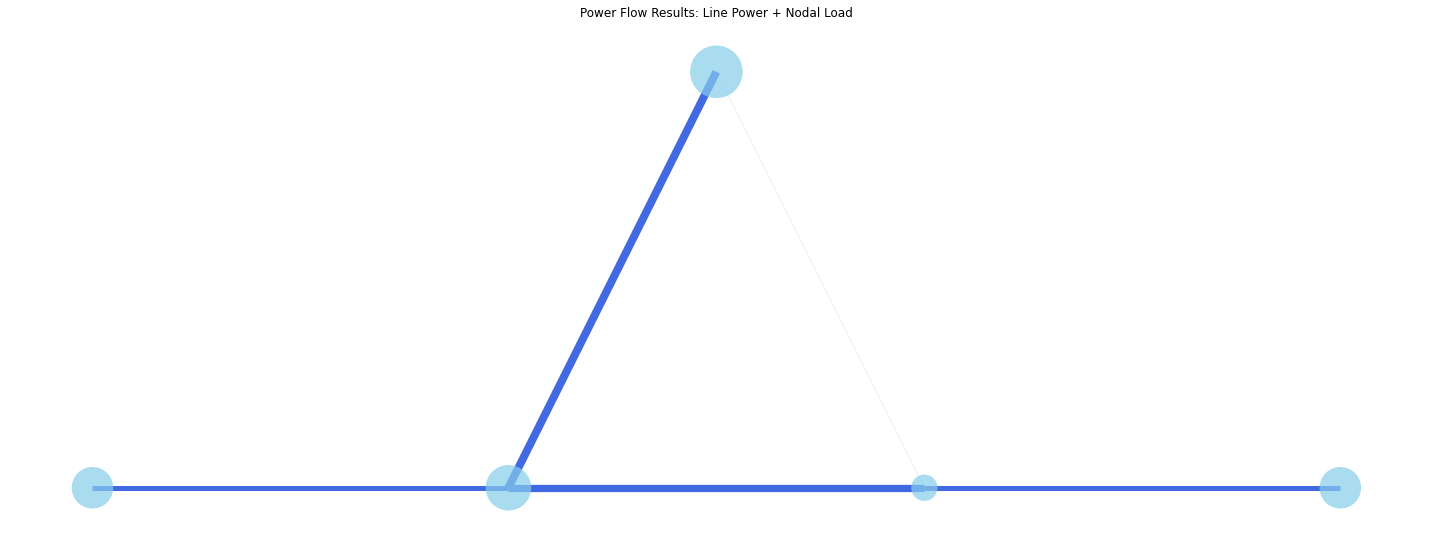

In [19]:
time_slot = 1;  # 0,1,...,23

# Visualization of Line Power Flow and Load
now = network.snapshots[time_slot]
loading = network.lines_t.p0.loc[now]
load_distribution = (network.loads_t.p_set.loc[now].groupby(network.loads.bus).sum())
fig, ax = plt.subplots(figsize=(20,10))
network.plot(ax=ax, geomap=False, line_widths=abs(loading*20), line_colors= 'royalblue',line_cmap=plt.cm.jet, title="Power Flow Results: Line Power + Nodal Load",
            bus_sizes= 1e-2*load_distribution, bus_colors = 'skyblue', bus_alpha=.7)
fig.tight_layout();

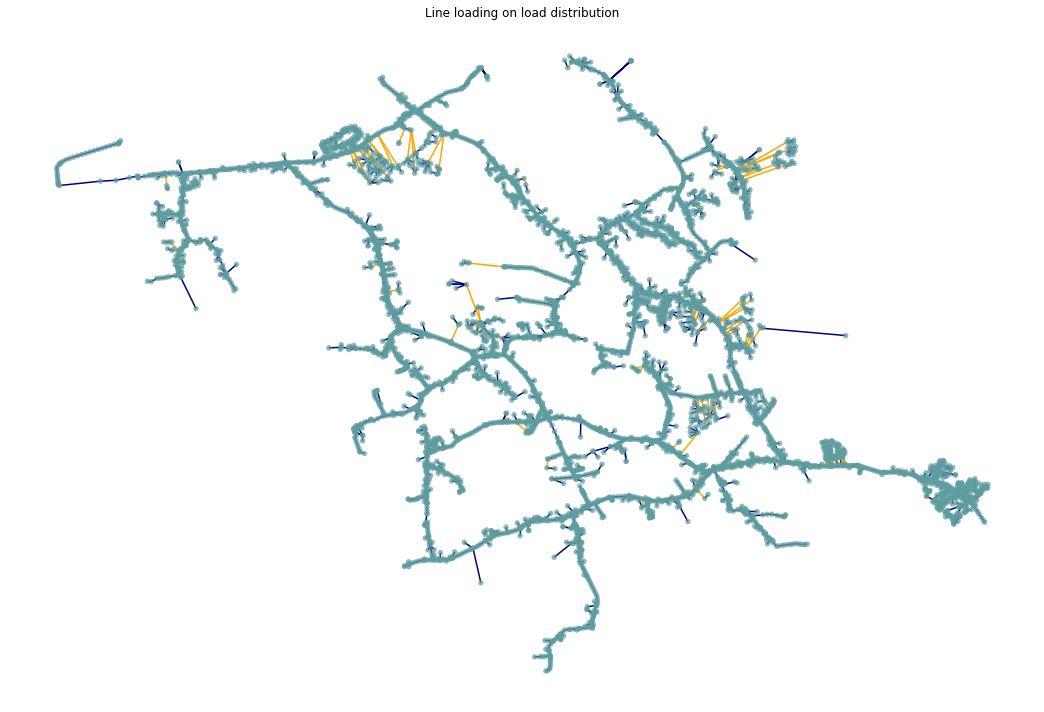

In [42]:
# Visualization of Power Lines and Load (Buses)
now = network.snapshots[time_slot]
loading = network.lines_t.p0.loc[now]
load_distribution = (network.loads_t.p_set.loc[now].groupby(network.loads.bus).sum())
fig, ax = plt.subplots(figsize=(20,10))
#network.plot(ax=ax, geomap=False, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading on load distribution",
#            bus_sizes= 1e-7, bus_alpha=.7)
network.plot(ax=ax, geomap=False, line_colors=1e-4, line_cmap=plt.cm.jet, title="Line loading on load distribution",
            bus_sizes= 2e-7, bus_alpha=.7)
fig.tight_layout();

(0.0, 6.0)

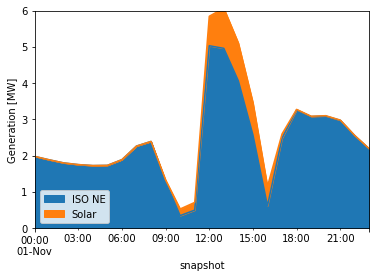

In [43]:
# Total power from different types of generators
p_carrier = network.generators_t.p.groupby(network.generators.carrier,axis=1).sum()
p_carrier.plot(kind='area')
plt.ylabel('Generation [MW]')
plt.legend(loc='lower left')
plt.ylim([0,6])

## Run Carbon Flow and Visualization

In [107]:
def RunCarbonFlow(network, time_slot, vis_flag):
    
    # =============== Carbon Flow Setup =================
    # 1- Generator Info
    num_gen = len(network.generators);  # total generator number
    P_gen_day = network.generators_t.p;   # all generations over a day
    P_gen_t = P_gen_day.iloc[[time_slot]].to_numpy()[0];     # generations at time slot t = 0;   
    gen_CED = np.array([1, 1, 0, 0, 0]);   # generation carbon emission density (CED)

    # 2- Branch Info 
    num_line = len(network.lines); # total line number
    num_tranf = len(network.transformers);  # total transformer number
    line_info = network.lines;
    tranf_info = network.transformers;
    line_info['row_num'] = np.arange(len(line_info)); # add row number
    tranf_info['row_num'] = np.arange(len(tranf_info)); # add row number

    P0_line_t = network.lines_t.p0.iloc[[time_slot]].to_numpy()[0];
    P1_line_t = network.lines_t.p1.iloc[[time_slot]].to_numpy()[0];

    P0_tranf_t = network.transformers_t.p0.iloc[[time_slot]].to_numpy()[0];
    P1_tranf_t = network.transformers_t.p1.iloc[[time_slot]].to_numpy()[0];

    # 3- Bus Info
    num_bus = len(network.buses); # total bus number
    bus_info = network.buses; 
    bus_info['row_num'] = np.arange(len(bus_info)); # add row number

    # 4-Load Info
    load_t = network.loads_t.p.iloc[[time_slot]];
    num_load = load_t.shape[1]
    
    # Total Load 
    P_load_sum = load_t.sum(axis=1)[0]
    print('Total Load: ', P_load_sum)

    # Total Line Loss
    P_lineloss = (P0_line_t + P1_line_t)
    P_lineloss_sum = P_lineloss.sum()
    print('Total Line Loss: ', P_lineloss_sum)

    # Total Transformer Loss
    P_tranf_loss = P0_tranf_t + P1_tranf_t
    P_tranf_loss_sum = P_tranf_loss.sum()
    print('Total Transformer Loss: ', P_tranf_loss_sum)
    
    
    # =============== Construct Carbon Flow Matrices and Run Power Flow ===================
    # 1- generation matrix
    P_G = np.zeros((num_bus, num_gen));
    for i in range(num_gen):
        bus_index = bus_info.loc[bus_info.index == network.generators.iat[i,0]]['row_num'].to_numpy()[0];
        P_G[bus_index, i] = P_gen_t[i];


    # 2- branch injection matrix
    P_bin = np.zeros((num_bus, num_bus)); # row: receiving-bus; column: sending-bus
    for i in range(num_line):
        P0_line = P0_line_t[i];
        P1_line = P1_line_t[i];
        bus0_name = line_info.iat[i,0];
        bus1_name = line_info.iat[i,1];
        if P0_line > 0:
            re_bus_name = bus1_name;    
            se_bus_name = bus0_name;
            P_re = P0_line;
        else:
            re_bus_name = bus0_name;    
            se_bus_name = bus1_name;
            P_re = P1_line;

        re_bus_index = bus_info.loc[bus_info.index == re_bus_name]['row_num'].to_numpy()[0];
        se_bus_index = bus_info.loc[bus_info.index == se_bus_name]['row_num'].to_numpy()[0];
        P_bin[re_bus_index, se_bus_index] = P_re;
       # print(P_re);

    for i in range(num_tranf):
        P0_tranf = P0_tranf_t[i];
        P1_tranf = P1_tranf_t[i];
        bus0_name = tranf_info.iat[i,0];
        bus1_name = tranf_info.iat[i,1];
        if P0_tranf > 0:
            re_bus_name = bus1_name;    
            se_bus_name = bus0_name;
            P_re = P0_tranf;
        else:
            re_bus_name = bus0_name;    
            se_bus_name = bus1_name;
            P_re = P1_tranf;

        re_bus_index = bus_info.loc[bus_info.index == re_bus_name]['row_num'].to_numpy()[0];
        se_bus_index = bus_info.loc[bus_info.index == se_bus_name]['row_num'].to_numpy()[0];
        P_bin[re_bus_index, se_bus_index] = P_re;
        # print(re_bus_name);    

    # 3- Nodal power in-flows
    P_N = np.dot(P_bin, np.ones((num_bus,1)) ) + np.dot(P_G, np.ones((num_gen,1)) );
    P_N_diag = np.diag(np.reshape(P_N, len(P_N)));  
    
    # ================ Run Carbon Flow ==========
    r_G = np.dot(P_G, gen_CED);
    d_N = np.dot(inv(P_N_diag - P_bin), r_G)   # compute nodal carbon emission density

    # Carbon Emission for Load
    E_load = np.zeros((num_load, 1));
    for i in range(num_load):
        bus_name = network.loads.iat[i,0];
        bus_index = bus_info.loc[bus_info.index == bus_name]['row_num'].to_numpy()[0];
        E_load[i] = load_t.iat[0,i]*d_N[bus_index];

   # sum(E_load)

    # Carbon Emission for Line Loss
    E_lnloss = np.zeros((num_line, 1));
    E_tfloss = np.zeros((num_tranf, 1));

    for i in range(num_line):
        P0_line = P0_line_t[i];
        P1_line = P1_line_t[i];
        bus0_name = line_info.iat[i,0];
        bus1_name = line_info.iat[i,1];
        if P0_line > 0:
            se_bus_name = bus0_name;
        else:   
            se_bus_name = bus1_name;

        se_bus_index = bus_info.loc[bus_info.index == se_bus_name]['row_num'].to_numpy()[0];
        E_lnloss[i] = abs(P0_line + P1_line)*d_N[se_bus_index];

    for i in range(num_tranf):
        P0_tranf = P0_tranf_t[i];
        P1_tranf = P1_tranf_t[i];
        bus0_name = tranf_info.iat[i,0];
        bus1_name = tranf_info.iat[i,1];
        if P0_tranf > 0:
            se_bus_name = bus0_name;
        else:
            se_bus_name = bus1_name;

        se_bus_index = bus_info.loc[bus_info.index == se_bus_name]['row_num'].to_numpy()[0];
        E_tfloss[i] = abs(P0_tranf + P1_tranf)*d_N[se_bus_index];


    E_consumption = sum(E_load) + sum(E_lnloss) + sum(E_tfloss)
    E_consumption = E_consumption[0]
    print('Consumption-side emission: ', E_consumption);

    E_generation = np.dot(P_gen_t, gen_CED)
    print('Generation-side emission: ', E_generation);

    print('Load emission: ', sum(E_load)[0], ' ', sum(E_load)[0]/E_consumption);
    print('Line loss emission: ',sum(E_lnloss)[0], ' ', sum(E_lnloss)[0]/E_consumption);
    print('Transformer loss emission: ',sum(E_tfloss)[0], ' ', sum(E_tfloss)[0]/E_consumption);
    
    # visualization of carbon flow emission
    if vis_flag == 1:
        # Visualization of Line Power Flow and Load
        now = network.snapshots[time_slot]
        e_line_loss = network.lines_t.p0.loc[now]
        for ind in range(num_line):
            e_line_loss[ind] = E_lnloss[ind,0]

        e_load = network.loads_t.p_set.loc[now];
        for ind in range(num_load):
            e_load[ind] = E_load[ind,0]

        e_load_distribution = (e_load.groupby(network.loads.bus).sum());

        # NED_distribution = (network.loads_t.p_set.loc[now].groupby(network.loads.bus).sum());
        # for ind in range(load_distribution.index.shape[0]):
          #  bus_index = network.buses.iloc[network.buses.index ==  NED_distribution.index[0]]['row_num'];
          #  NED_distribution[ind] = d_N[bus_index[0]]
        fig, ax = plt.subplots(figsize=(20,10))
        network.plot(ax=ax, geomap=False, line_widths=abs(e_line_loss*1.5e4), line_colors='teal', line_cmap=plt.cm.jet, title="Power Flow Results: Line Power + Nodal Load",
                    bus_sizes= 5.5e-5*e_load_distribution, bus_colors = 'cadetblue', bus_alpha=.7)
        fig.tight_layout();
     
    
    # summarize all the results
    cf = {'Total Load': [P_load_sum], 'Total Line Loss': [P_lineloss_sum], 'Total Transformer Loss': [P_tranf_loss_sum],
          'Load Emission': [sum(E_load)[0]], 'Line Loss Emission':  [sum(E_lnloss)[0]], 'Transformer Loss Emission': [sum(E_tfloss)[0]],
          'Cons Emission': [ E_consumption], 'Gene Emission': [E_generation] }
    
    cf_results = pd.DataFrame( data = cf)
    time_index = pd.Index([str(network.generators_t.p.index[time_slot])])
    cf_results = cf_results.set_index(time_index)
    return cf_results
    

In [115]:
cf_day = RunCarbonFlow(network, 0, 0)
for time_slot in range(1,24):
    cf_results =  RunCarbonFlow(network, time_slot, 0)
    cf_day = cf_day.append(cf_results)

Total Load:  1.8987338449999998
Total Line Loss:  0.05537242319839375
Total Transformer Loss:  0.0286827561669876
Consumption-side emission:  1.98159004143649
Generation-side emission:  1.981589025175947
Load emission:  1.8975367710399453   0.9575829164262387
Line loss emission:  0.05537114374244087   0.02794278462476595
Transformer loss emission:  0.028682126654103753   0.014474298948995306
Total Load:  1.8110314989999998
Total Line Loss:  0.05084096939445395
Total Transformer Loss:  0.026067764950476777
Consumption-side emission:  1.8879402334677156
Generation-side emission:  1.8879402334540714
Load emission:  1.8110314990002399   0.9592631519239293
Line loss emission:  0.050840969516998825   0.02692933209205228
Transformer loss emission:  0.026067764950476777   0.013807515984018328


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Total Load:  1.730996074
Total Line Loss:  0.04693692892750807
Total Transformer Loss:  0.02380153843048004
Consumption-side emission:  1.8017345414810442
Generation-side emission:  1.8017345412316217
Load emission:  1.730996074000234   0.9607386849437528
Line loss emission:  0.04693692905033037   0.026050968091974155
Transformer loss emission:  0.023801538430480034   0.013210346964273065
Total Load: 

<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


 1.68770468
Total Line Loss:  0.04509616489076903
Total Transformer Loss:  0.022695482866730593
Consumption-side emission:  1.7552463397108398
Generation-side emission:  1.755246327536338
Load emission:  1.687454923240333   0.961377833448908
Line loss emission:  0.04509604663450649   0.025692146802559712
Transformer loss emission:  0.022695369836000123   0.012930019748532261
Total Load:  1.662870426
Total Line Loss:  0.04412083199796105
Total Transformer Loss:  0.02209993552471638


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Consumption-side emission:  1.7280079105742432
Generation-side emission:  1.728007860565765
Load emission:  1.6617881230858742   0.9616785391530047
Line loss emission:  0.04412033068395988   0.025532481890836962
Transformer loss emission:  0.022099456804409078   0.012788978956158305
Total Load:  1.665143274
Total Line Loss:  0.04610388231666278
Total Transformer Loss:  0.023190116206097264


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Consumption-side emission:  1.7341039545578172
Generation-side emission:  1.734103939707279
Load emission:  1.6648102407249012   0.9600406229102999
Line loss emission:  0.04610373666243516   0.02658648954767608
Transformer loss emission:  0.023189977170480915   0.013372887542024075
Total Load: 

<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


 1.807119842
Total Line Loss:  0.055822598813925026
Total Transformer Loss:  0.02852409713814288
Consumption-side emission:  1.8914665380764244
Generation-side emission:  1.891466537210772
Load emission:  1.807119842000239   0.9554067204583149
Line loss emission:  0.05582259893804257   0.029512866241246223
Transformer loss emission:  0.028524097138142877   0.015080413300438925
Total Load:  2.147328905
Total Line Loss:  0.0781048099666144
Total Transformer Loss:  0.04123598544053677


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Consumption-side emission:  2.266669700542606
Generation-side emission:  2.2666696968248177
Load emission:  2.147328905000242   0.947349719496495
Line loss emission:  0.07810481010182711   0.034457958335583704
Transformer loss emission:  0.04123598544053677   0.018192322167921292
Total Load: 

<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


 2.255218182
Total Line Loss:  0.09091629489567335
Total Transformer Loss:  0.04797802824190532
Consumption-side emission:  2.3941125052599133
Generation-side emission:  2.3941124815555783
Load emission:  2.255218182000234   0.9419850475052758
Line loss emission:  0.09091629501777394   0.03797494679887809
Transformer loss emission:  0.0479780282419053   0.02004000569584621
Total Load:  1.27354461
Total Line Loss:  0.04047443610599543
Total Transformer Loss:  0.018788720606277957


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Consumption-side emission:  1.28839325008564
Generation-side emission:  1.2883910841753277
Load emission:  1.229347809851146   0.9541712592560001
Line loss emission:  0.04027105785570733   0.031256805989188854
Transformer loss emission:  0.018774382378786966   0.014571934754811099


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Total Load:  0.5008055420000002
Total Line Loss:  0.021627184914713354
Total Transformer Loss:  0.008158066638525481
Consumption-side emission:  0.34734255765134037
Generation-side emission:  0.34734081099260267
Load emission:  0.3254823263802513   0.9370643452996273
Line loss emission:  0.01606843382064562   0.046261056892357495
Transformer loss emission:  0.00579179745044343   0.016674597808015192
Total Load:  0.6762134990000002
Total Line Loss:  0.025643440230294405
Total Transformer Loss:  0.009866250963184537


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Consumption-side emission:  0.49905665627408075
Generation-side emission:  0.4990564937667273
Load emission:  0.4684585301526893   0.938688071310711
Line loss emission:  0.022068031198429643   0.0442194907551938
Transformer loss emission:  0.008530094922961829   0.017092437934095244
Total Load:  5.326289922
Total Line Loss:  0.33793785592857295
Total Transformer Loss:  0.1842399455894019


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Consumption-side emission:  5.0349975261868645
Generation-side emission:  5.034967435937017
Load emission:  4.523772810620465   0.8984657464263814
Line loss emission:  0.32863834411013515   0.06527080547724153
Transformer loss emission:  0.18258637145626413   0.036263448096377035
Total Load: 

<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


 5.56332794
Total Line Loss:  0.3300824483925747
Total Transformer Loss:  0.17861115252747178
Consumption-side emission:  4.963398268904359
Generation-side emission:  4.963354623231294
Load emission:  4.470856779990886   0.9007652696340649
Line loss emission:  0.3162425229279585   0.0637149198582783
Transformer loss emission:  0.17629896598551448   0.03551981050765677
Total Load:  4.761500685000001
Total Line Loss:  0.22723902092435197
Total Transformer Loss:  0.12089276470522374


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Consumption-side emission:  4.0648368122474094
Generation-side emission:  4.064799087130848
Load emission:  3.7298688275054177   0.9175937435587258
Line loss emission:  0.21593982451613722   0.05312386068378134
Transformer loss emission:  0.11902816022585486   0.029282395757492988
Total Load:  3.319252928
Total Line Loss:  0.10000484321904624


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Total Transformer Loss:  0.05007568742869067
Consumption-side emission:  2.576938539005821
Generation-side emission:  2.57691678964228
Load emission:  2.4352670827016443   0.945023346828119
Line loss emission:  0.09274884364542632   0.03599187261998444
Transformer loss emission:  0.04892261265875069   0.018984780551896653
Total Load:  1.1384943240000003
Total Line Loss:  0.013560692940115499
Total Transformer Loss:  0.003600776734357904


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Consumption-side emission:  0.6189902362770301
Generation-side emission:  0.6189891267873235
Load emission:  0.6050557968526541   0.977488434214753
Line loss emission:  0.010770927123320218   0.017400802940128562
Transformer loss emission:  0.0031635123010558667   0.005110762845118661
Total Load:  2.4734222000000003
Total Line Loss:  0.08358826850123302
Total Transformer Loss:  0.04501318425155308


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Consumption-side emission:  2.482436447665884
Generation-side emission:  2.482440319102591
Load emission:  2.3545589520937815   0.94848710197905
Line loss emission:  0.0829762691395557   0.03342533470195151
Transformer loss emission:  0.04490122643254616   0.018087563318998412


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Total Load:  3.0624599270000004
Total Line Loss:  0.1389357886173867
Total Transformer Loss:  0.07730981831729054
Consumption-side emission:  3.268968895144161
Generation-side emission:  3.268955528522281
Load emission:  3.0527515913784997   0.9338576441988059
Line loss emission:  0.13891597725036295   0.04249534997311034
Transformer loss emission:  0.07730132651529843   0.023647005828083736
Total Load:  2.896853496
Total Line Loss:  0.12428108153736966
Total Transformer Loss:  0.06879377804228497


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Consumption-side emission:  3.082524262575635
Generation-side emission:  3.0825116854116006
Load emission:  2.889470650212278   0.9373715838323852
Line loss emission:  0.12426574484299184   0.040312981912804254
Transformer loss emission:  0.06878786752036473   0.022315434254810477
Total Load:  2.910335685
Total Line Loss:  0.12531417162270367
Total Transformer Loss:  0.06937196642975438


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Consumption-side emission:  3.096620499815093
Generation-side emission:  3.096605152595669
Load emission:  2.9019546568688246   0.9371360349264973
Line loss emission:  0.12530016068290273   0.0404635184357866
Transformer loss emission:  0.06936568226336576   0.022400446637716103
Total Load:  2.8032275
Total Line Loss:  0.11626484228998038
Total Transformer Loss:  0.06412479256533378


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Consumption-side emission:  2.9772083331304158
Generation-side emission:  2.977200465471083
Load emission:  2.7968351373231304   0.9394153261630737
Line loss emission:  0.11625341311957826   0.03904779246581728
Transformer loss emission:  0.06411978268770731   0.021536881371109127
Total Load: 

<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


 2.42314502
Total Line Loss:  0.08718775987059378
Total Transformer Loss:  0.04717789359242101
Consumption-side emission:  2.550600361078865
Generation-side emission:  2.55059400667609
Load emission:  2.4162516193880057   0.947326620139726
Line loss emission:  0.08717577647392462   0.0341785321621497
Transformer loss emission:  0.04717296521693451   0.018494847698124324


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


Total Load:  2.089168318
Total Line Loss:  0.06559217479745821
Total Transformer Loss:  0.03464443475533699
Consumption-side emission:  2.1832437883846643
Generation-side emission:  2.183238260351186
Load emission:  2.0830184906730898   0.9540934007256564
Line loss emission:  0.06558443592601075   0.030039904968439318
Transformer loss emission:  0.03464086178556366   0.015866694305904195


<ipython-input-115-ba4e3ad0751a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cf_day = cf_day.append(cf_results)


In [117]:
cf_day.to_csv('carbonflowresults.csv');

In [190]:
cf_day2= cf_day.reset_index()
cf_day2.head(3)

,index,Total Load,Total Line Loss,Total Transformer Loss,Load Emission,Line Loss Emission,Transformer Loss Emission,Cons Emission,Gene Emission
0,2021-11-01 00:00:00,1.898734,0.055372,0.028683,1.897537,0.055371,0.028682,1.981590,1.981589
1,2021-11-01 01:00:00,1.811031,0.050841,0.026068,1.811031,0.050841,0.026068,1.887940,1.887940
2,2021-11-01 02:00:00,1.730996,0.046937,0.023802,1.730996,0.046937,0.023802,1.801735,1.801735


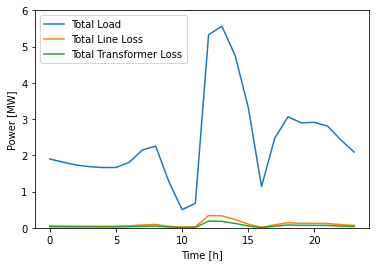

In [125]:
cf_day2[ ['Total Load', 'Total Line Loss', 'Total Transformer Loss' ] ].plot()
plt.ylabel('Power [MW]')
plt.xlabel('Time [h]')
plt.ylim([0,6])
plt.show()

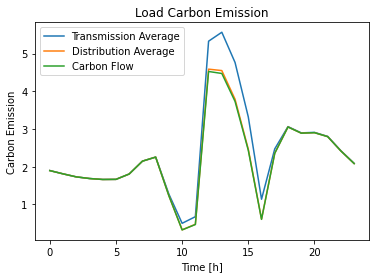

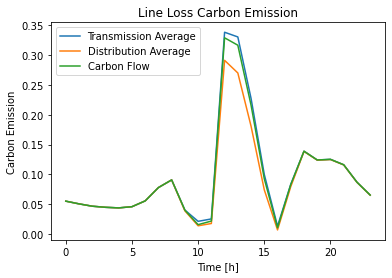

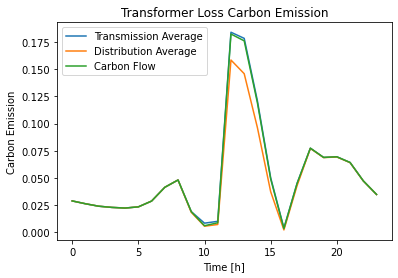

In [192]:
P_Gen =  np.array(p_carrier.sum(axis =1))
E_Gen = np.array(cf_day2[ ['Gene Emission']]).reshape( np.array(p_carrier.sum(axis =1)).shape)
d_ave = E_Gen/P_Gen
e_dist_load = d_ave*(np.array(cf_day2[ ['Total Load']]).reshape( np.array(p_carrier.sum(axis =1)).shape))
e_dist_line = d_ave*(np.array(cf_day2[ ['Total Line Loss']]).reshape( np.array(p_carrier.sum(axis =1)).shape))
e_tranf_line = d_ave*(np.array(cf_day2[ ['Total Transformer Loss']]).reshape( np.array(p_carrier.sum(axis =1)).shape))

# Load Carbon Emission
plt.plot(cf_day2[ ['Total Load'] ], label = 'Transmission Average')
plt.plot( e_dist_load , label = 'Distribution Average')
plt.plot(cf_day2[ ['Load Emission'] ], label = 'Carbon Flow')
plt.legend(loc="upper left")
plt.xlabel('Time [h]');
plt.ylabel('Carbon Emission');
plt.title('Load Carbon Emission')
plt.show()

# Line Loss Carbon Emission
plt.plot(cf_day2[ ['Total Line Loss'] ], label = 'Transmission Average')
plt.plot( e_dist_line , label = 'Distribution Average')
plt.plot(cf_day2[ ['Line Loss Emission'] ], label = 'Carbon Flow')
plt.legend(loc="upper left")
plt.xlabel('Time [h]');
plt.ylabel('Carbon Emission');
plt.title('Line Loss Carbon Emission')
plt.show()

# Line Transformer Carbon Emission
plt.plot(cf_day2[ ['Total Transformer Loss'] ], label = 'Transmission Average')
plt.plot( e_tranf_line , label = 'Distribution Average')
plt.plot(cf_day2[ ['Transformer Loss Emission'] ], label = 'Carbon Flow')
plt.legend(loc="upper left")
plt.xlabel('Time [h]');
plt.ylabel('Carbon Emission');
plt.title('Transformer Loss Carbon Emission')
plt.show()

In [ ]:
cf_day[]

In [28]:
# lines with zero power flows
line_0power = network.lines.index[abs(P0_line_t)<1e-7]
print(line_0power)
print(line_0power.shape)

Index([], dtype='object', name='Line')
(0,)


In [29]:
# nodes with zero power in-flows
bus_0flux = network.buses.index[abs(P_N[:,0])<1e-7]
print(bus_0flux)
print(bus_0flux.shape)

NameError: name 'P_N' is not defined

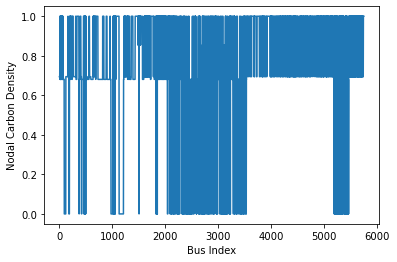

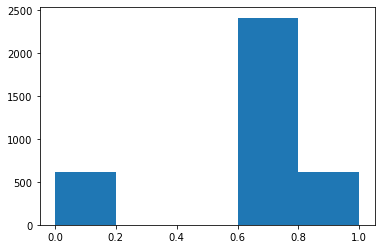

In [518]:
xaxis = range(len(d_N))
plt.plot(xaxis, d_N)
plt.xlabel('Bus Index')
plt.ylabel('Nodal Carbon Density')
plt.show()
plt.hist(d_N, bins = [0,  0.2,  0.4, 0.6, 0.8, 1])
plt.show()

0.005581467014699229
0.5783952439111241
0.005581461377008838
0.005419958132562153
0.00016149761705916855
0.2513468678752498
0.0023120325602981645
0.00017099034202948895
0.258535841056798
0.634869290598442
0.06471612950942575
6.050629793166662e-05
0.6410280526784461
5.870109530016758e-05
0.00022300538869777579
0.028501632475985923
5.870109727718527e-05
1.139915245175493e-05
0.0011516890688497833
1.1399150350427382e-05
1.1399150358874726e-05
6.041826714952902e-12
5.377518710612318e-13
4.0307028629707944e-12
6.755852455697826e-12
8.606094964341599e-12
1.0556965379295436e-11
0.001219259881727234
1.556338489811129
0.005433743507531264
0.059405342459839715
1.557013977298293
1.5576894722352388
1.5583649746176182
1.5590404844425314
1.5597160017027956
1.5603915263969903
1.5627759739926845
0.0005358878764664743
0.0014961295264250792
0.17783655081467747
0.6285194882729169
5.100015408241837e-12
2.7940896555495528e-12
6.72608766869752e-12
6.4329051688804645e-12
6.188143594160914e-12
2.9681940671263

0.22629177740741221
0.057500446544465726
0.22629653610187775
0.2263012947988478
0.09729465469556704
0.0009453093067808524
0.09729613564403591
0.09729761659742571
0.0972990975563864
0.09730057852050401
0.05104101669281681
0.051040584927819134
0.05104015315637451
4.034983330734854e-12
0.08016687751233699
0.7778589093607002
1.0461469726927948e-13
0.13593214754135607
0.0012618487357161472
0.13593429766281262
0.13593644778248337
0.6983235423521953
0.06129338879427068
0.35425825280363027
0.0612924896058643
0.06119574923742978
0.060993006067338346
0.0511095119644276
0.30779034182294296
5.753101534039014e-05
2.998060530574626e-11
2.3227883546501926e-11
1.338997174300492
1.3392029951036872
1.3568708746574767
6.351423777325651e-06
6.351423815470529e-06
0.12108646205535316
0.7761237455349815
0.001988712933340776
0.001988712549158982
0.08017268178579968
4.622594280662657e-12
0.0801711381504539
0.0006824572018421684
0.07895631290772422
0.0006824570366207659
0.0006824568766606759
0.00068245672161520

1.7583438738161186e-05
1.5744861193353135e-05
1.4541429129638444e-05
1.4307428824906947e-05
1.203428065570149e-05
1.1399137049650385e-05
7.822276381403e-06
6.184276808097285e-06
5.448847933701099e-06
2.5405656033202603e-06
5.077834147099014e-05
1.5444003399126974e-05
8.828606050841104e-05
8.370621422465217e-05
6.983300005140282e-05
6.107452686691333e-05
6.074023540593794e-05
5.8433618925190566e-05
5.799903856268234e-05
5.4321830223910775e-05
5.2884376084216636e-05
5.2483226764063235e-05
5.074491261350724e-05
4.870573841737863e-05
4.7803153194463696e-05
4.4794538309322084e-05
4.195307094909894e-05
3.9312181357164386e-05
3.901132095509527e-05
3.81421674059679e-05
3.754044657073723e-05
3.637043437402612e-05
3.6236717982622856e-05
3.586900025619316e-05
3.573528397642773e-05
3.560156872208799e-05
3.493298992428388e-05
3.439812760341806e-05
3.376297882334387e-05
3.3060972140893676e-05
3.3060972135690745e-05
3.222524918153411e-05
3.2058105588237044e-05
3.2024676044096826e-05
3.135609922320733

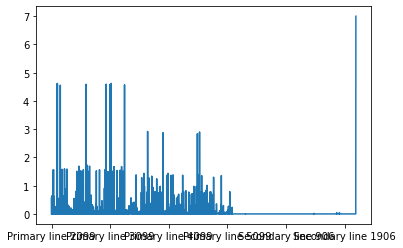

In [103]:
linepower = abs(network.lines_t.p0.min())
linepower.plot()

np.where(linepower == np.min(linepower))

linepower[2288]

for x in linepower:
   # if linepower[x] < 1e-8
    print(x)

In [78]:
# Total line losses from all lines
power_losses = network.lines_t.p0 + network.lines_t.p1

sum(power_losses.values)

array([2.47097714e-04, 2.79911297e-04, 2.47097510e-04, ...,
       5.08947363e-08, 6.77736999e-01, 7.73643429e-01])

Text(0, 0.5, 'Power Loss [MW]')

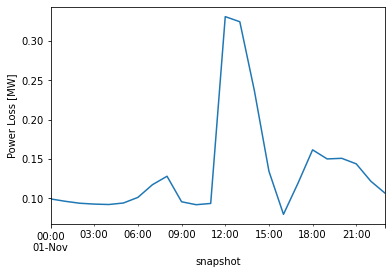

In [84]:
loss_total_t = power_losses.sum(axis = 1)
loss_total_t.plot()
plt.ylabel('Power Loss [MW]')

In [11]:
# Daily line loss from each line
power_losses.sum(axis=0)

Primary line 2099        2.470977e-04
Primary line 2100        2.799113e-04
Primary line 2101        2.470975e-04
Primary line 2102        2.440554e-04
Primary line 2103        3.045787e-08
                             ...     
Secondary line 2096      2.842485e-06
Secondary line 2097      1.905247e-06
Secondary line 2098      5.089474e-08
Transmission line 112    6.777370e-01
Transmission line 114    7.736434e-01
Length: 5195, dtype: float64

In [85]:
# Total power with equal weight of ISO NE and solar power sources
network.snapshot_weightings.generators @ network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()

carrier
ISO NE    56.379954
Solar      5.003950
Name: generators, dtype: float64

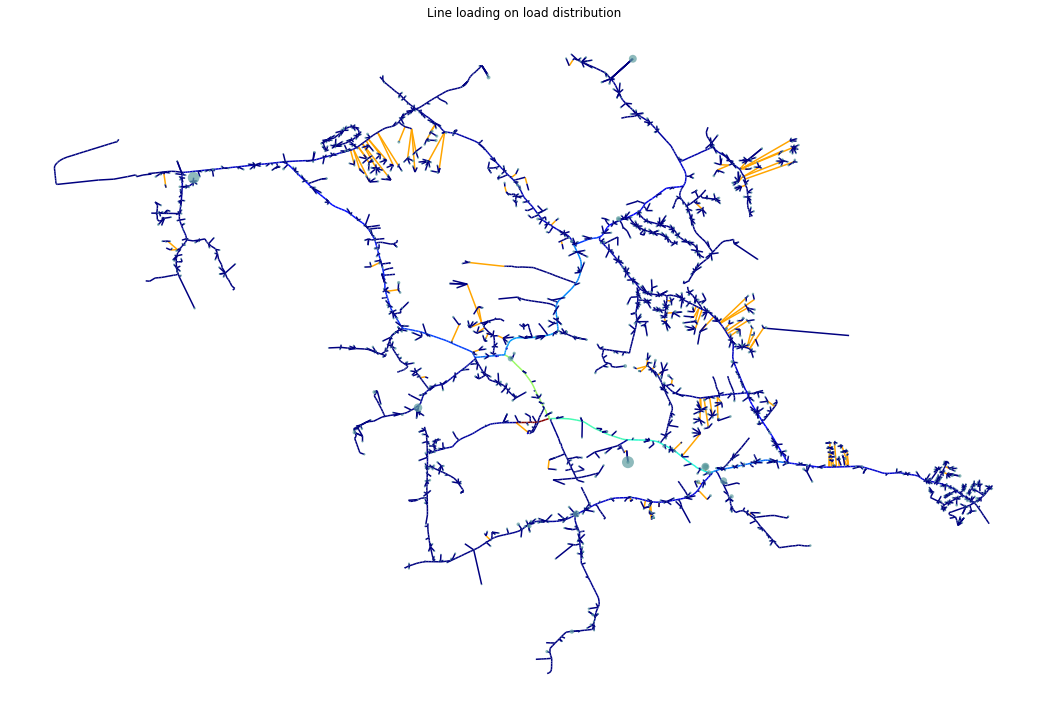

In [4]:
now = network.snapshots[23]
loading = network.lines_t.p0.loc[now]
load_distribution = (network.loads_t.p_set.loc[now].groupby(network.loads.bus).sum())
fig, ax = plt.subplots(figsize=(20,10))
network.plot(ax=ax, geomap=False, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading on load distribution",
            bus_sizes=0.2e-4*load_distribution, bus_alpha=.7)
fig.tight_layout();

/home/jeff/.virtualenvs/eversource/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/jeff/.virtualenvs/eversource/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/jeff/.virtualenvs/eversource/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


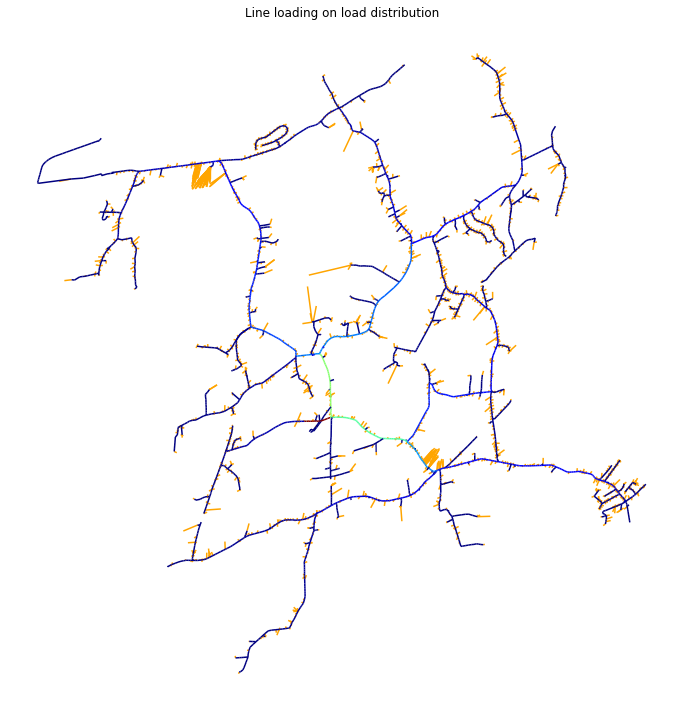

In [8]:
# Color-coded line loading on load distribution 
now = network.snapshots[23]
loading = network.lines_t.p0.loc[now]
load_distribution = (network.loads_t.p_set.loc[now].groupby(network.loads.bus).sum())
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.EqualEarth()}, figsize=(20,10))
network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading on load distribution",
            bus_sizes=0.2e-4*load_distribution, bus_alpha=.7)
fig.tight_layout();

* What do the transformer data mean? total power flows through the transformer? (MW, active power )
* The transformer data in Sheet 4 is the sum over all transformers? 

In [86]:
# Transfromers in Rochester station doesn't have MW reading; therfore, use MVA reading with power factor equals to 1 for comparsion 
df_trans = pd.read_excel('Transformer_MVA.xlsx','Sheet4')
df_trans.Time = pd.to_datetime(df_trans.Time)
df_trans['Hour']= pd.DatetimeIndex(df_trans['Time']).hour
df_trans = df_trans.groupby(pd.Grouper(key='Hour')).mean() 

* The transformer data are from 7/1/2021, while the generation and load data are from 11/1/2021, why not choose the same day?
* That is why the df_trans does not match the generation above?

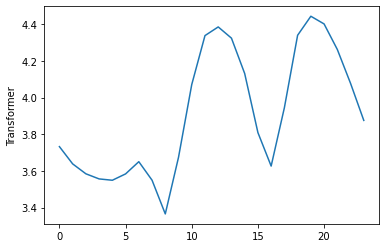

In [87]:
plt.plot(df_trans)
plt.ylabel('Transformer')
plt.show()

In [15]:
# Solar farm KW reading. COnvert from KW to MW.
df_s61 = pd.read_excel('ASU47061.xlsx','Sheet4')
df_s61.Time = pd.to_datetime(df_s61.Time)
df_s61['Hour']= pd.DatetimeIndex(df_s61['Time']).hour
dg_s61 = df_s61.groupby(pd.Grouper(key='Hour')).mean() 
dg_s61['AVG']=dg_s61.MW_p3.values*0.001

df_s53 = pd.read_excel('ASU47053.xlsx','Sheet4')
df_s53.Time = pd.to_datetime(df_s53.Time)
df_s53['Hour']= pd.DatetimeIndex(df_s53['Time']).hour
dg_s53 = df_s53.groupby(pd.Grouper(key='Hour')).mean() 
dg_s53['AVG']=dg_s53.MW_p3.values*0.001

df_s23 = pd.read_excel('ASU47023.xlsx','Sheet4')
df_s23.Time = pd.to_datetime(df_s23.Time)
df_s23['Hour']= pd.DatetimeIndex(df_s23['Time']).hour
dg_s23 = df_s23.groupby(pd.Grouper(key='Hour')).mean() 
dg_s23['AVG']=dg_s23.MW_p3.values*0.001

* Why does the solar generation here not match the generation above? 

Becasue the data here is on 7/1/2021 and the data above is on 11/1/2021?

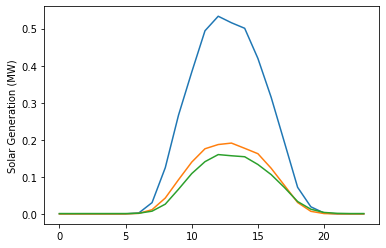

In [31]:
plt.plot(dg_s61['AVG'])
plt.ylabel('Solar Generation (MW)')
plt.plot(dg_s53['AVG'])
plt.plot(dg_s23['AVG'])
plt.show()

In [17]:
# Simulated generators' power
Network_power = pd.DataFrame(network.generators_t.p)
Network_power['Solar'] = Network_power['My gen 3'] + Network_power['My gen 2'] + Network_power['My gen 1'] 
Network_power['Total'] = Network_power['My gen 3'] + Network_power['My gen 2'] + Network_power['My gen 1'] + Network_power['My gen 0']
Network_power=Network_power.reset_index()

# Generators' power reading from Eversource system 
Pi_power = pd.DataFrame()
Pi_power['Ngas']=df_trans['MW_p3'].values
Pi_power['Solar']=dg_s23['AVG'].values+dg_s53['AVG'].values+dg_s61['AVG'].values
Pi_power['Total']=Pi_power['Ngas']+Pi_power['Solar']

KeyError: 'My gen 0'

* Why is "network.generators_t.p" called "simulated generators' power"? Are they not real measurement?
* Why do we compare these two datasets? They are not from the same day? We can see the plots below are quite different.
* So the total load is the sum over all transformer loads?

KeyError: 'snapshot'

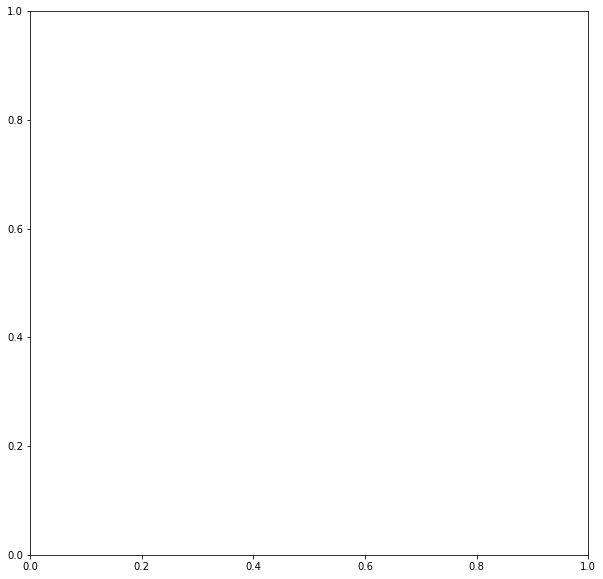

In [18]:
# Error rate plot
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(Network_power['snapshot'],(Network_power['Total']-Pi_power['Total'])/Pi_power['Total']*100,'-o',label = 'Total power error rate')
plt.plot(Network_power['snapshot'],(Network_power['My gen 0']-Pi_power['Ngas'])/Pi_power['Ngas']*100,'-o',label = 'ISO NE power error rate')
plt.plot(Network_power['snapshot'],(Network_power['Solar']-Pi_power['Solar'])/Pi_power['Solar']*100,'-o',label = 'Solar power error rate')

plt.ylabel('Error rate [%]')
plt.xlabel('Hour')
plt.ylim([-1000,1000])
plt.legend()

* What does the CO2 reading mean? What is the definition? (total carbon emission or emission factors?) What is the unit? Oct 1- Oct5?
* The C02 reading contains 5days * 24 hours = 120 time slots, then why combine them to 24 hours?

In [20]:
# Average daily CO2 reading using Oct 1 to Oct 4 2021
CO2 = pd.read_csv('CO2_Oct1_Oct4.csv')
CO2.index = CO2.start_date
CO2.index=pd.to_datetime(CO2.index)
CO2['Hour'] = CO2.index.hour
CO2_hr = CO2.groupby(by=["Hour"]).mean()

(500.0, 1000.0)

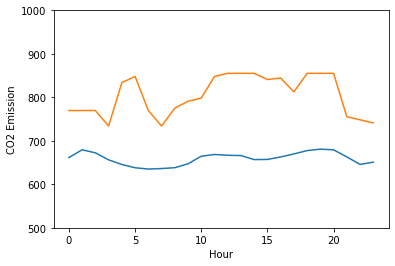

In [21]:
plt.plot(CO2_hr)
plt.ylabel('CO2 Emission')
plt.xlabel('Hour')
plt.ylim([500,1000])

* Where the factor 527.6 come from? 

In [22]:
# Calculating emission loss using interger and real time singularity  
CO2_Lineloss_int = 527.6*power_losses.sum(axis=1)
CO2_Lineloss_total = CO2_hr['data.marginal_rate'].values *power_losses.sum(axis=1)

KeyError: 'snapshot'

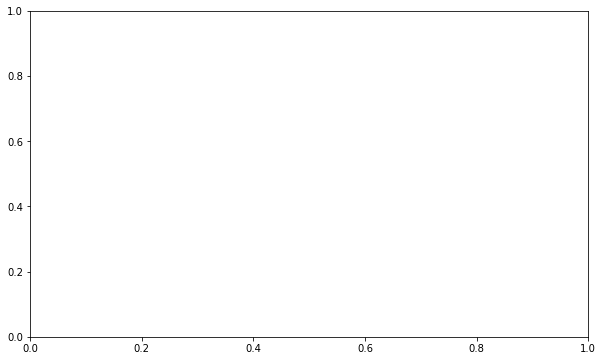

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(Network_power['snapshot'],CO2_Lineloss_total,'r*-',label='Real CO2 using simulated line loss real time  power')
plt.plot(Network_power['snapshot'],CO2_Lineloss_int,'k--',label='Constant CO2 using simulated line loss real time  power')
plt.title('Emission using simulation power')
plt.xlabel('Hour')
plt.ylabel('CO2 (lbs)')
plt.ylim([0,350])
plt.legend()